In [30]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/drive')
%cd /drive/MyDrive/data/pipotron/
%pwd
%ls -al

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/MyDrive/data/pipotron
total 100
drwx------ 2 root root  4096 Mar 16 10:48 donnees/
drwx------ 8 root root  4096 Mar 16 10:40 .git/
-rw------- 1 root root  1819 Mar 16 11:10 .gitignore
-rw------- 1 root root  4451 Mar 16 12:39 git.ipynb
drwx------ 3 root root  4096 Mar 16 10:46 models/
-rw------- 1 root root 82075 Mar 17 08:59 pipotron_entrainement.ipynb
-rw------- 1 root root    79 Mar 16 10:40 README.md


In [2]:
# Chargement des données :

from_full_table = False
reviews_filename = "donnees/review_only.txt"

if from_full_table:
  # Chargement du fichier complet, issu du scraping du site larvf.com (données accessibles par abonnement, non publiques):
  DF_rvf = pd.read_csv("/drive/MyDrive/donnees/larvf_2020-11-24.csv")
  print("Nombre de revues textuelles disponibles :", len(DF_rvf)-DF_rvf['review_text'].isna().sum())

  # On sélectionne la colonne qui nous intéresse en retirant les valeurs manquantes, et on fait un mélange aléatoire: 
  S_reviews = DF_rvf['review_text'][~DF_rvf['review_text'].isna()].sample(frac=1, random_state=5406).reset_index(drop=True)
  display(S_reviews.head(4))
  
  # On enregistre ces données pour ce projet:
  S_reviews.to_csv(reviews_filename, header=False, index=False)

else:
  S_reviews = pd.read_csv(reviews_filename, header=None).iloc[:, 0]
  display(S_reviews.head(4))


0    Cette cuvée a gagné en élégance et en délicate...
1    Bonne trame acide. Légères notes animales à l’...
2    Réservé, à la fois pur et nerveux, il s'appuie...
3    Un assemblage de meunier et chardonnay, pas d’...
Name: 0, dtype: object

In [3]:
# Préparation des données:
import re

# On ajoute un nouveau mot (token) qui a vocation à servir de déclencheur pour générer un nouveau commentaire de dégustation.
# On supprime également les informations de date du commentaire, parfois présentes.
# Enfin on ajoute un token de fin de séquence pour inciter le modèle à produire des commentaires de taille raisonnable.
L_first_tokens = ["<|review|>"]
L_reviews = [L_first_tokens[0] + " " + re.sub(r"\([^\(\)]*\.[0-9][0-9][0-9][0-9]\)", "", review.strip()) for review in list(S_reviews)]
L_reviews = [review + " <|end|>" for review in L_reviews]

# Affichons le résultat de cette préparation sur quelques lignes:
for i in range(27,32):
  print(L_reviews[i])

<|review|> On sent des vignes qui ont du fond dans un vin mûr et structuré, qui reste simple en finale. <|end|>
<|review|> Un véritable jus de caillou croquant et tonique, un vin plein de répartie, singulier dans l'éclat très ferme de son fruit tendu, d'une rare intensité désaltérante et juteuse. <|end|>
<|review|> Il s’exprime sur le fruit noir. Il mêle virilité et élégance, avec une forte empreinte du terroir. <|end|>
<|review|> Derrière une fine réduction, il livre une note d’épices et de garrigue. Il lui faut un peu d’air pour libérer son fruit. Il offre une très belle qualité du fruit, du relief avec une jolie assise tannique mais sans dureté. Long en bouche, il possède un beau potentiel de garde et d’évolution. <|end|>
<|review|> Les vendanges ont été plus tardives qu’à Haut-Brion, mais le vin conserve une réelle fraîcheur et un fruit sapide. Beaucoup de crémeux avec une fine sucrosité et un boisé doux (60 % de bois neuf). Bouche de grand équilibre avec une saveur saline en final

In [4]:
# On vérifie le nombre de lignes:
print(len(L_reviews))

30667


In [66]:
# On va s'appuyer sur un modèle de générateur GPT-2 (merci OpenAI) pré-entraîné sur la langue française (merci Antoine Louis),
# et on utilise la bibliothèque transformers (merci à HuggingFace): 
!pip install transformers
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
import tensorflow as tf

# On charge le modèle pré-entraîné et son tokenizer associé:
model_name = "antoiloui/belgpt2"
model = TFGPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
nb_added_tokens = 0

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at antoiloui/belgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [67]:
# On ajoute des tokens de déclenchement et de padding au tokenizer, et on prépare le modèle à recevoir ces nouveaux tokens:
nb_added_tokens += tokenizer.add_special_tokens({'pad_token': "<|pad|>", 'eos_token':"<|end|>"})
if len(L_first_tokens)>0:
    nb_added_tokens += tokenizer.add_special_tokens({'additional_special_tokens': L_first_tokens})
print(nb_added_tokens, "token(s) ajoutés")

_ = model.resize_token_embeddings(tokenizer.vocab_size + nb_added_tokens)

3 token(s) ajoutés


In [68]:
# On vérifie la bonne définition des tokens de padding et de fin de séquence :
print(tokenizer.pad_token, ":", tokenizer.pad_token_id)
assert tokenizer.pad_token_id!=None
print(tokenizer.eos_token, ":", tokenizer.eos_token_id)
assert tokenizer.eos_token_id!=None

<|pad|> : 50257
<|end|> : 50258


In [69]:
# On vérifie qu'un commentaire de vin est inchangé après tokenisation puis détokenisation:
i = 4449
print(L_reviews[i])

print(tokenizer.decode(tokenizer.encode(L_reviews[i])))
assert L_reviews[i] == tokenizer.decode(tokenizer.encode(L_reviews[i]))

<|review|> La précision de la matière entretient la force qui se dégage de ce vin. Amples, les tanins encore denses restent intégrés à la matière et soutiennent un fruité généreux. Les notes de cacao portent l'allonge avec puissance. <|end|>
<|review|> La précision de la matière entretient la force qui se dégage de ce vin. Amples, les tanins encore denses restent intégrés à la matière et soutiennent un fruité généreux. Les notes de cacao portent l'allonge avec puissance. <|end|>


In [70]:
# On génère un commentaire aléatoire, avant entraînement spécifique (fine tuning) donc non exploitable à ce stade:

# TO DO: optimiser si besoin (?) les paramètres de génération aléatoire 
# cf. https://blog.fastforwardlabs.com/2019/05/29/open-ended-text-generation.html

def pipote(max_length=200, skip_special_tokens=True):
  input = tokenizer.encode(L_first_tokens[0], return_tensors='tf')
  output = model.generate(
      input_ids=input,
      max_length=max_length,
      do_sample=True,
      pad_token_id=tokenizer.pad_token_id 
  )
  return tokenizer.decode(output[0], skip_special_tokens=skip_special_tokens)

print(pipote())

' t de quoi? Il veut qu' on lui fasse honneur aussi bien dans sa maison que chez lui ; mais rien... Rien... Il veut être grand. L' occasion m' est donnée de mettre le point sur le sujet de cette très belle exposition. Les autres modèles d' exception seront vendus dès le 15 décembre 2009. La famille le trouve toujours un peu froid dans sa chambre, mais lorsqu' ils commencent à parler, le couple s' empresse de se rapprocher pour avoir la chance d' avoir leur fille dans leurs bras. En utilisant cette technique, nous nous sommes assurés que l' état de l' air est parfaitement " propre " et que dans certains cas il ne l' est pas assez pour être dangereux, comme par exemple fumer par temps chaud. Je ne parle pas ici de tous les éléments à savoir. C' est là toute l' importance de cet ouvrage, pour la compréhension de la Bible. De retour à La Réunion en novembre 2013, en tant que directeur général en


64.0
27729


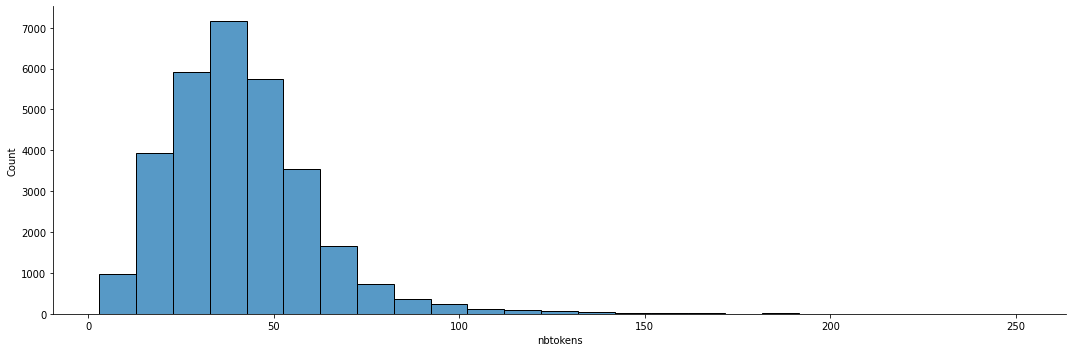

In [71]:
# Pour limiter les calculs inutiles et le besoin de padding, on ne va garder que 90% des revues, celles ayant le plus faible nombre de tokens.
# Le seuil calculé ci-dessous est à 64 tokens.
import seaborn as sns
unpadded = tokenizer(L_reviews, padding=False)
L_nbtokens = [len(t) for t in unpadded.input_ids]
DF_nbtokens = pd.DataFrame(pd.Series(L_nbtokens, name='nbtokens'))
sns.displot(kind='hist', data=DF_nbtokens, x='nbtokens', bins=25, aspect=3)
threshold = DF_nbtokens.nbtokens.quantile(0.9)
print(threshold)

L_short_reviews = [L_reviews[i] for i in range(0, len(L_reviews)) if L_nbtokens[i]<=threshold]
print(len(L_short_reviews))

In [72]:
# On prépare les données d'entraînement du générateur:
# Le générateur prédit le mot suivant pour chaque mot (ou plutôt token, en l'occurrence wordpiece) du texte fourni en entrée.
# Donc l'ensemble d'apprentissage est constitué de tuples (x=entrée, y=sortie) où y est un décalage de x d'un token vers la droite.

batch_size = 16
train_size = int(0.80*len(L_short_reviews)/batch_size)*batch_size
print("Taille des batches :", batch_size)
print("Nombre de lignes dans la base d'apprentissage :", train_size)

encodings = tokenizer(L_short_reviews, padding=True, return_tensors='tf')
input_ids = encodings.input_ids
attention_mask = encodings.attention_mask
x = {'input_ids': input_ids[:, :-1], 'attention_mask': attention_mask[:, :-1]}
y = input_ids[:, 1:]
assert x['input_ids'].shape == y.shape
assert x['attention_mask'].shape == y.shape
full_dataset = tf.data.Dataset.from_tensor_slices((x, y))
train_dataset = full_dataset.take(train_size).batch(batch_size).repeat()
test_dataset = full_dataset.skip(train_size).batch(batch_size)

Taille des batches : 16
Nombre de lignes dans la base d'apprentissage : 22176


In [73]:
# On "encapsule" le modèle initial dans un modèle qui ne renvoie que les "logit" des probabilités des mots,
# ce à quoi on peut appliquer la fonction de coût classique (entropie croisée)

class Pipotron(tf.keras.Model):
  def __init__(self, model):
    super().__init__(name="Pipotron")
    self.gpt2 = model
  def __call__(self, input, training=False):    
    y = self.gpt2(input, training=training)
    return y.logits

pipotron = Pipotron(model)

In [74]:
# On contrôle les formats d'entrée et de sortie du modèle (à ce stade il est déboussolé par notre token de déclenchement):
for features, labels in train_dataset.take(1):
  i=4
  for k in features.keys():
    print(k, ":", features[k].shape)
  print(tokenizer.decode(features['input_ids'][i], skip_special_tokens=False))
  print("labels :", labels.shape)
  print(tokenizer.decode(labels[i], skip_special_tokens=False))
  z = pipotron(features)
  print("output :", z.shape)
  print(tokenizer.decode(tf.math.argmax(z[i], axis=-1), skip_special_tokens=False))

input_ids : (16, 63)
attention_mask : (16, 63)
<|review|> Un viognier fidèle à son bouquet exubérant, agréable et fluide. <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>
labels : (16, 63)
Un viognier fidèle à son bouquet exubérant, agréable et fluide. <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>
output : (16, 63, 50260)
'iversdeurn

In [75]:
# Paramétrage de l'entraînement :

# TO DO : appliquer un learning_rate dégressif évolutif ?

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
pipotron.compile(optimizer=optimizer, loss=loss)

In [ ]:
# ENTRAINEMENT (fine tuning) DU MODELE :

# Pour voir la progression, on affiche le score à chaque 'round' (pseudo-epoch, qui est en fait une subdivision de la 'vraie' epoch
# si on considère qu'une vraie epoch consiste à passer toute la base d'entraînement une fois):
nb_epochs = 5
nb_steps_per_round = 400
nb_rounds = (nb_epochs*len(L_short_reviews))//(batch_size*nb_steps_per_round)
print("Nombre d'étapes (rounds) d'entraînement prévues :", nb_rounds)
H_history = pipotron.fit(train_dataset, validation_data=test_dataset, epochs=nb_rounds, steps_per_epoch=nb_steps_per_round)


Nombre d'étapes (rounds) d'entraînement prévues : 21
Epoch 1/21
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silen

In [ ]:
# Sauvegarde du modèle:
import time

fullpath = "models/pipotron_" + str(int(time.time()/60))
model.save_pretrained(fullpath)
print("MODEL SAVED AT :", fullpath)

In [13]:
# Rechargement du modèle, si besoin :

fullpath = "models/pipotron_26931474"
model = TFGPT2LMHeadModel.from_pretrained(fullpath)
pipotron = Pipotron(model)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at models/pipotron_26931474.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [14]:
# On affiche un exemple de commentaire généré par le modèle entraîné:
print(pipote())


Un fruit bien expressif, avec une petite touche d'alcool, sur des arômes fumés. La bouche est ample et large, avec des tanins présents mais bien équilibrés. Belle allonge. Corset a été créée en 1970 et a pris sa pleine dimension en 2001. Un vin racé.


In [46]:
# Code de test, A SUPPRIMER (pour bien interpréter la fonction de coût (loss))

for x, ytrue in test_dataset.take(1):
  ypred_logit = pipotron(x)
  ypred = tf.keras.activations.softmax(ypred_logit)
  print(ypred.shape)
  print(type(x['input_ids']))
  print(x['input_ids'].shape)
  #print(tokenizer.decode(x['input_ids'][0]))
  #print(tokenizer.decode(ytrue[0]))
  #print(tokenizer.decode(tf.math.argmax(ypred[0], axis=-1)))
  #print(tf.math.reduce_max(ypred[0], axis=-1))
  L_proba = [ypred[0, wp, ytrue[0, wp]].numpy() for wp in range(0, x['input_ids'].shape[1])]
  L_log = [-np.log(p) for p in L_proba]
  print(L_proba)
  print(L_log)
  print("Calcul manuel de la cross entropy :", np.mean(L_log))
  print("Calcul par la fonction avec logits=True et aggrégation automatique :", loss(ytrue[[0]], ypred_logit[[0]]))
  print("Calcul par la fonction avec softmax manuel, logits=False et aggrégation automatique :", tf.keras.losses.SparseCategoricalCrossentropy()(ytrue[:1], ypred[:1]))
  loss2 = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  z = loss2(ytrue[:1], ypred[:1])
  print("Calcul par la fonction avec logits=False et aggrégation manuelle :", z)
  print(tf.reduce_mean(z))


(16, 250, 50260)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 250)
[0.001094727, 0.62489265, 0.09311333, 0.8183387, 0.2364887, 0.015966944, 0.010694073, 0.6817045, 0.26131544, 0.007629169, 0.00010274026, 0.8877495, 0.9994221, 0.012027676, 0.7127236, 0.005193919, 0.20330457, 0.50257313, 0.03159934, 0.061603017, 0.048487667, 0.0009430915, 0.84833044, 0.0384862, 0.6284416, 0.0029421214, 0.17510642, 0.038885277, 0.0018042829, 0.0012440161, 0.0008610667, 0.17916352, 0.12814155, 0.0023394967, 0.4549562, 0.0012356754, 0.21942392, 0.7452575, 0.023454243, 0.6364435, 0.9867569, 0.99999976, 0.99999976, 0.99999976, 0.9999999, 0.99999976, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 

[37, 37, 51, 28, 17, 36, 21, 41, 38, 45]
